In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matrix
import pickle
import util

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import VarianceThreshold

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load results

In [2]:
datapath = "/home/asd/data/gsm/"
savepath = "/home/asd/saved/"

factors = {}
for alg in matrix.get_models(50, 10).keys():
    factors[alg] = {}
    for t in matrix.TIME_POINTS:
        W = np.load(savepath + "embryo" + str(t) + "_" + alg + "_W.npy")
        H = np.load(savepath + "embryo" + str(t) + "_" + alg + "_H.npy")
        factors[alg][t] = matrix.clean_factors(W, H)

In [26]:
data18 = util.load_regular_sample_file(datapath, 18)

In [27]:
lda = LatentDirichletAllocation(n_components=6, n_jobs=-1)
lda.fit(data18)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=6, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [34]:
H18lda = lda.components_
W18lda = lda.transform(data18)

### Plot factors

0.9329751043754306


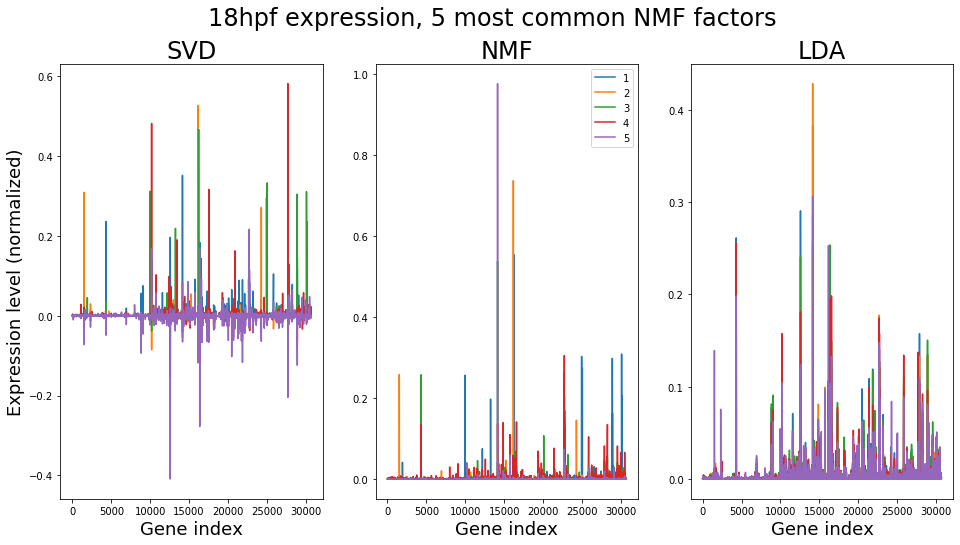

In [55]:
#W24, H24 = factors['nmf'][24]
W18, H18 = factors['nmf'][18]
W18p, H18p = factors['svd'][18]
W18lda, H18lda = matrix.clean_factors(W18lda, H18lda)


plt.figure(figsize=(16, 8))
plt.suptitle("18hpf expression, 5 most common NMF factors", fontsize=24)
for (title, data, i) in [
    ("SVD", H18p, 1),
    ("NMF", H18, 2),
    #("24hpf expression, 5 most common NMF factors", H24),
    ("LDA", H18lda, 3)
]:
    plt.subplot(1, 3, i)
    plt.plot(data[0:5, :].T)
    
    if (i == 2):
        plt.legend(range(1, 6))
    plt.title(title, fontsize=24)
    plt.xlabel("Gene index", fontsize=18)
    if (i == 1):
        plt.ylabel("Expression level (normalized)", fontsize=18)

plt.savefig("/home/asd/final221/18hpf_all.png")
print(matrix.score_factor_pairing(H18, H24))

### Project data onto NMF factors

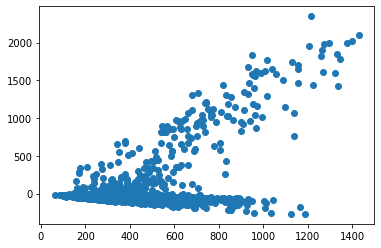

In [24]:
plt.figure()
plt.scatter(W18p[:, 0], W18p[:, 1])
plt.show()

### Now have these models vary over time

We have data that varies over time, but comes from the same underlying "process." Let's model this as a series of matrix factorizations. Our objective function will be

$$ 
J(W, H) 
= 
\sum_{t=1}^T  \| W^{(t)} H^{(t)} - X^{(t)} \|_F^2 
+ \sum_{t=2}^T  \| H^{(t)} - H^{(t-1)} \|_F^2 
+ R(W, H)
$$

where $R(W,H)$ is an additional regularizer, e.g. nonnegativity, sparsity, etc.

Some questions:
- What if we formulate this as a Bayesian network, where the factors $H$ form a Markov process, but ottherwise everything is the same.
- Is there a natural Bayesian network interpretation of these update rules, which can then be generalized to larger networks?